# Variational Autoencoders (VAEs)

In [13]:
import jax.numpy as jnp
import jax
from jax import random

from flax import linen as nn
from einops import rearrange
import optax
import tensorflow as tf
from tqdm import trange
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_probability.substrates.jax as tfp

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

## The dataset

We'll simply use MNIST.

In [14]:
def get_mnist_dataset(split):
    """Returns a raw array of the MNIST dataset."""
    # Load the dataset
    ds = tfds.load('mnist', split=split, shuffle_files=True if split == "train" else False)

    # Define a function to preprocess each batch
    def preprocess(batch):
        images = batch['image']
        # Flatten the images and normalize their pixel values to [0, 1]
        images = tf.cast(images, tf.float32) / 255.
        labels = batch['label']
        return images, labels

    # Map the preprocessing function to each batch
    ds = ds.map(preprocess)
    
    # Convert the tf.data.Dataset into an iterable of NumPy arrays
    numpy_ds = tfds.as_numpy(ds)

    # Convert the iterable of NumPy arrays into a single NumPy array
    images, labels = zip(*list(numpy_ds))
    images = jnp.array(images)
    labels = jnp.array(labels)

    return images, labels

x, labels = get_mnist_dataset("train")

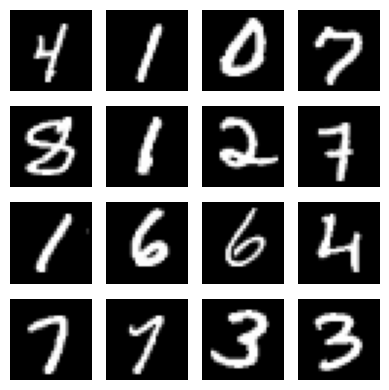

In [15]:
# Plot a few images in a grid
fig, ax = plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(ax.flat):
    ax.imshow(x[i], cmap="gray")
    ax.set_axis_off()
plt.tight_layout()

## The variational autoencoder (VAE)

### Vanilla VAEs

Boiled down to its essence, a VAE is a *Bayesian latent-variable model trained with variational inference*. 
$$\mathrm{"VAE = BLVM + VI".}$$
The basic idea is to build a latent-variable model $p(x,z)$ where the "true" data likelihood $q(x)$ has a high marginal likelihood $p(x) =  \int \mathrm dz \, p(x,z) $. The high-dimensional integral over $z$ makes this formally intractable.

We write down a forward process (the approximate posterior, or latent-variable model),
$$q(x,z) = q(z|x)\,q(x).$$
and a reverse process (the generative model, or reconstruction bit),
$$p(x,z) = p(x\mid z)\,p(z)$$
and try to align the two by minimizing the KL divergence between them,
$$D_\mathrm{KL}\left(q(x,z)\,\|\,p(x,z)\right) = \mathbb E_{x, z\sim q(x, z)}\left[\frac{\log q(x,z)}{\log p(x, z)}\right].$$

We additionally have (leaving the expectation over $p(x, z)$ implicit)
$$\mathbb E \left[\frac{\log q(x,z)}{\log p(x, z)}\right] = \mathbb E \left[\frac{\log q(x)}{\log p(x)}\right] + \mathbb E \left[\frac{\log q(z\mid x)}{\log p(z\mid x)}\right] \geq \mathbb E \left[\frac{\log q(x)}{\log p(x)}\right] \geq 0$$
using the non-negativity of the KL divergence. The intuition behind the first equality is that the distance between two joint distributions will always be at least as much as their marginals. 

Decomposing the ratio of the joints as our specific choice of forward and reverse processes, we have
$$\mathbb E\left[\log q(x)-\log p(x \mid z)+\log \frac{q(z \mid x)}{p(z)}\right] \geq \mathbb E \left[\frac{\log q(x)}{\log p(x)}\right]$$
which can be massaged to give the canonical form of the VAE objective (omitting the expectation over $x\sim q(z)$ for clarity),
$$\log q(x) \geq \mathbb E_{z\sim q(z\mid x)}\left[\log p_\theta(x\mid z)\right] - D_\mathrm{KL}(q_\phi(z \mid x)\,\|\,p(z)) \equiv \mathrm{ELBO},$$
the Evidence Lower BOund (ELBO), a lower bound on the marginal likelihood of the data. The VAE is typically trained by minimizing $-\mathbb E_{x\sim q(x)}\left[\mathrm{ELBO}\right]$, and we've explicitly denoted the parameterized *encoder* $q_\phi(z\mid x)$ and *decoder* $p_\theta(x\mid z)$ distributions.

### $\beta$-VAEs and neural compression

The VAE loss objective can be written as
$$\mathcal L = -\mathbb E_{z\sim q(z\mid x)}\left[\log p_\theta(x\mid z)\right] + D_\mathrm{KL}\left(q_\phi(z \mid x)\,\|\,p(z)\right)$$
where, in the language of neural compression, the first (reconstruction) term is often called the *distortion* and the second (regularization) term is called the *rate*.

1. **Distortion:** The distortion corresponds to how well the VAE can reconstruct the input data from the latent space. This is captured by the reconstruction term of the ELBO, often modeled by the log-likelihood of the data under the decoder's distribution. In the Gaussian case, the log-likelihood is equivalent to the Mean Squared Error (MSE) between the original and reconstructed data. Hence, the distortion $D(x)$ for an input $x$ is defined as the negative reconstruction log-likelihood:

$$D(x) = -\mathbb{E}_{z \sim q_\phi(z|x)}\left[\log p_\theta(x|z)\right]$$

2. **Rate:** The rate corresponds to the complexity of the learned latent space, measured by the Kullback-Leibler (KL) divergence between the encoder's distribution $q_\phi(z|x)$ and the prior $p(z)$ (typically a standard Gaussian). This term serves as a regularization that encourages the learned latent representation to adhere to the prior. For an input $x$, the rate $R(x)$ is defined as:

$$R(x) = D_\mathrm{KL}\left(q_\phi(z|x)\,\|\,p(z)\right)$$

In the context of $\beta$-VAEs, the hyperparameter $\beta$ is used to control the trade-off between the distortion and the rate, allowing us to tune the balance between reconstruction quality and complexity of the latent space, $$\mathcal L = D(x) + \beta\cdot R(x).$$

### What does it mean to have a "simpler" latent space?

A larger $\beta$ encourages $q_\phi(z\mid x)$ to closely match the prior distribution, typically a unit Gaussian $p(z) = \mathcal N(0, \mathbb I)$. This limits the amount of information that the latent space can carry about the input data $x \sim q(x)$. For a more "complex" latent space (smaller $\beta$), more bits of data would be needed to pinpoint where in the latent space a particular data point lies. $\beta = 0$ corresponds to a plain autoencoder, where individual input data points could in principle be mapped to arbitrary points in the latent space. This can lead to a model where the latent space is not continuous, and latent points between those corresponding to the training data points are not semantically meaningful.

### Disentangled representations

The pressure towards simplicity (larger $\beta$) encourages disentanglement of the latent space; a *disentangled representation* refers to a one where individual latent dimensions are sensitive to separate factors of variation in the data. Essentially, by modifying one dimension in the latent space, we alter one specific factor of the reconstructed data, leaving others mostly unchanged.

*When each dimension in the latent space has to carry less information about the specifics of the input data, the model is encouraged to use its more limited capacity more effectively.* This implicitly translates to aligning latent dimensions with independent (learned) factors of variation in the input data, effectively disentangling them.

### I don't want to add a random hyperparameter to my loss!

Understandable. Consider a Gaussian noise model for the data, $p_\theta(x\mid z) = \mathcal N(x\mid f_\theta(z), \sigma^2\mathbb I)$, where $f_\theta(z)$ is the mean returned by the decoder. Then, you can think of $\sigma$ as controlling the "sharpness" of the reconstructed distribution; a larger $\sigma$ means that more of the data variation is allowed to be explained by the noise, and less by the latent space (simpler latent space, heuristically equivalent to a larger $\beta$). Let's spell this out explicitly.

In this context, a smaller $\sigma$ (which corresponds to a sharper, less noisy reconstruction) will lead the VAE to capture more variation in the data within the latent space. The decoder is highly confident about its outputs, and therefore, it tries to replicate the original data as closely as possible, leaving little room for reconstruction noise. This pushes the encoder to map similar inputs to similar points in the latent space and to ensure that most variations in the data are captured in the latent variables.

On the other hand, a larger $\sigma$ allows the VAE to rely more on the noise to explain the data's variation. With less confident decoder outputs, the model is not pressured to reconstruct the input data as accurately. This gives the encoder more flexibility and allows the latent space to be less expressive. In other words, the latent variables do not need to capture all variations in the data because some of it can be attributed to the reconstruction noise.

We can therefore think of $\sigma$ as a proxy for $\beta$; a smaller $\sigma$ corresponds to a larger $\beta$, and vice versa. This can be a useful heuristic for understanding the effect of $\beta$ on the VAE's latent space.

## Implementation

We implement a $\beta$-VAE with a simple MLP encoder and decoder. We'll parameterize the encoder as well as decoder networks with $\beta$, and train a model by varying $\beta$. $\beta$-VAEs are often trained by annealing $\beta$ over the course of training, but the simple parameterized approach should suffice here.

In [16]:
class MLP(nn.Module):
    """ A simple MLP, used for the encoder and decoder.
    """
    hidden_dim: int = 256
    out_dim: int = 2
    n_layers: int = 4

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [17]:
class VAE(nn.Module):
    """ A simple variational auto-encoder module.
    """
    num_latents: int = 4
    num_out: int = 2

    def setup(self):
        self.encoder = MLP(out_dim=self.num_latents * 2)
        self.decoder = MLP(out_dim=28 * 28)

    def __call__(self, x, beta, z_rng):

        # Flatten x
        x = rearrange(x, 'b h w c -> b (h w c)')

        # Concatenate x and beta
        x = jnp.concatenate([x, beta], axis=-1)

        # Get variational parameters from encoder
        enc = self.encoder(x)  # Shape (batch_size, num_latents * 2)
        enc = rearrange(enc, 'b (n c) -> b n c', c=2)  # Reshape to (batch_size, num_latents, 2)
        mu, logvar = enc[:, :, 0], enc[:, :, 1]

        # Sample from variational distrib. of latents
        z = tfp.distributions.Normal(loc=mu, scale=jnp.exp(0.5 * logvar)).sample(seed=z_rng)

        # Concatenate z and beta
        z = jnp.concatenate([z, beta], axis=-1)
        
        # Decode
        recon_x = self.decoder(z)

        return recon_x, mu, logvar

@jax.vmap
def rate(mu, logvar):
    """ KL-divergence between latent variational distribution and unit Normal prior.
    """
    prior_latent = tfp.distributions.Normal(loc=0., scale=1.)  # Prior
    q_latent = tfp.distributions.Normal(loc=mu, scale=jnp.exp(0.5 * logvar))  # Variational latent distrib.

    return tfp.distributions.kl_divergence(q_latent, prior_latent)

@jax.vmap
def distortion(pred, true, beta):
    """ "Reconstruction" loss, Gaussian noise model.
    """
    true = rearrange(true, 'h w c -> (h w c)')
    # Restrict between 0 and 1 with sigmoid
    pred = nn.sigmoid(pred)
    log_prob = tfp.distributions.Normal(loc=pred, scale=beta).unnormalized_log_prob(true)
    return -log_prob

from functools import partial

@partial(jax.jit, static_argnums=(1,))
def loss_fn(params, vae, x_batch, log_beta_batch, z_rng):
    """ Loss function for the VAE, rate + distortion.
    """

    beta_batch = jnp.power(10., log_beta_batch)
    
    recon_x, mean, logvar = vae.apply(params, x_batch, beta_batch, z_rng)

    R = rate(mean, logvar).mean(-1)
    D = distortion(recon_x, x_batch, beta_batch).mean(-1)

    loss = D + R
    return loss.mean()

In [18]:
num_latents = 64
num_out = 28 * 28

vae = VAE(num_latents=num_latents, num_out=num_out)
key = jax.random.PRNGKey(42)
key, z_key = random.split(key)
_, params = vae.init_with_output(key, x[:16], jnp.ones((16, 1)), z_key)

In [19]:
print(loss_fn(params, vae, x[:128], jnp.ones((128, 1)) * 2.,  key))

6.2491755


### Model with a fixed $\beta$

In [20]:
n_steps = 2000
n_batch = 512

opt = optax.adam(learning_rate=3e-4)
opt_state = opt.init(params)

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]

        # Draw random batch of betas
        key, subkey = jax.random.split(key)
        log_beta_batch = jnp.ones((n_batch, 1)) * -1.

        # Get loss and update
        loss, grads = jax.value_and_grad(loss_fn)(params, vae, x_batch, log_beta_batch, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 2000/2000 [01:15<00:00, 26.49it/s, val=-0.109751135]  


Draw some samples.

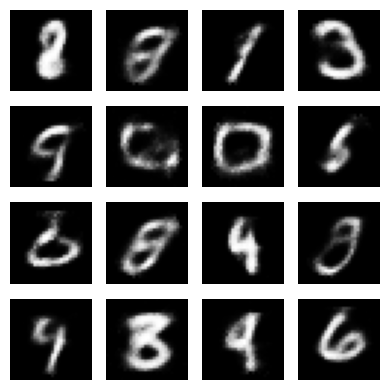

In [26]:
@jax.jit
def eval(params, z):
    """ Generate sample for a latent code z.
    """
    def eval_model(vae):
        return vae.decoder(z)
    return nn.sigmoid(nn.apply(eval_model, vae)(params))

z = jax.random.normal(key, shape=(16, num_latents))
z = jnp.concatenate([z, jnp.zeros((16, 1))], axis=-1)
x_samples = eval(params, z)

# Draw samples from model
x_samples = rearrange(x_samples, 'b (h w c) -> b h w c', h=28, w=28, c=1)

# Plot a few images in a grid
fig, ax = plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(ax.flat):
    ax.imshow(x_samples[i, :, :, 0], cmap="gray")
    ax.set_axis_off()
plt.tight_layout()

### Model with variable $\beta$

In [76]:
log_beta_min = -2.
log_beta_max = 2.

In [33]:
n_steps = 2000
n_batch = 512

opt = optax.adam(learning_rate=3e-4)
opt_state = opt.init(params)

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]

        # Draw random batch of betas
        key, subkey = jax.random.split(key)
        log_beta_batch = jax.random.uniform(key, shape=(n_batch, 1), minval=log_beta_min, maxval=log_beta_max)

        # Get loss and update
        loss, grads = jax.value_and_grad(loss_fn)(params, vae, x_batch, log_beta_batch, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 2000/2000 [01:13<00:00, 27.11it/s, val=4.1787176]


In [34]:
x_test, labels_test = get_mnist_dataset("test") 

Encode and reconstruct some samples.

In [70]:
@jax.jit
def get_RD(params, x, beta, key):
    """ Get rate-distortion for a batch of images x and a batch of betas beta.
    """
    x = rearrange(x, 'b h w c -> b (h w c)')
    x = jnp.concatenate([x, beta], axis=-1)
    def encode_decode_model(vae):
        enc = vae.encoder(x)
        enc = rearrange(enc, 'b (n c) -> b n c', c=2)
        mu, logvar = enc[:, :, 0], enc[:, :, 1]
        R = rate(mu, logvar)
        z = tfp.distributions.Normal(loc=mu, scale=jnp.exp(0.5 * logvar)).sample(seed=key)
        z = jnp.concatenate([z, beta], axis=-1)
        return vae.decoder(z), R
    
    x_reco, R = nn.apply(encode_decode_model, vae)(params)
    x = rearrange(x[..., :-1], 'b (h w c) -> b h w c', h=28, w=28, c=1)
    D = distortion(x_reco, x, jnp.ones_like(beta))
    return R.mean(-1).mean(), D.mean(-1).mean(), x_reco

Get rate, distortion, and reconstructions for various $\beta$.

In [77]:
log_beta_ary = jnp.linspace(log_beta_min, log_beta_max, 20)

n_test = 16

x_reco_list = []
R_list = []
D_list = []

for log_beta in log_beta_ary:
    beta = jnp.ones((n_test, 1)) * 10 ** log_beta
    R, D, x_reco = get_RD(params, x_test[:n_test], beta, key)
    R_list.append(R)
    D_list.append(D)
    x_reco = nn.sigmoid(rearrange(x_reco, 'b (h w c) -> b h w c', h=28, w=28, c=1))
    x_reco_list.append(x_reco)


Plot the rate-distortion curve.

Text(0.5, 0, 'Distortion')

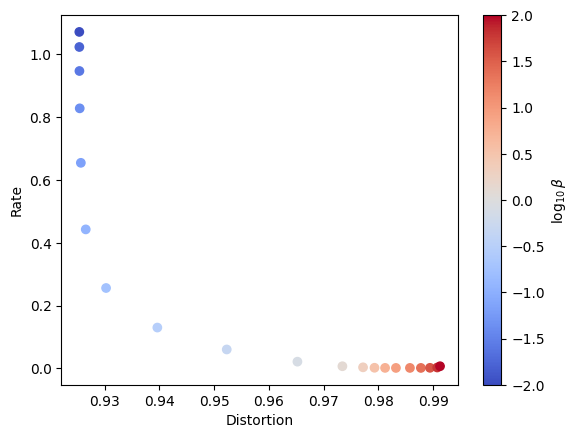

In [78]:
plt.scatter(D_list, R_list, c=log_beta_ary, cmap="coolwarm")
cbar = plt.colorbar(label=r'$\log_{10} \beta$')
cbar.mappable.set_clim(-2, 2)
plt.ylabel('Rate')
plt.xlabel('Distortion')

Look at what the reconstruction looks like for increasing $\beta$.

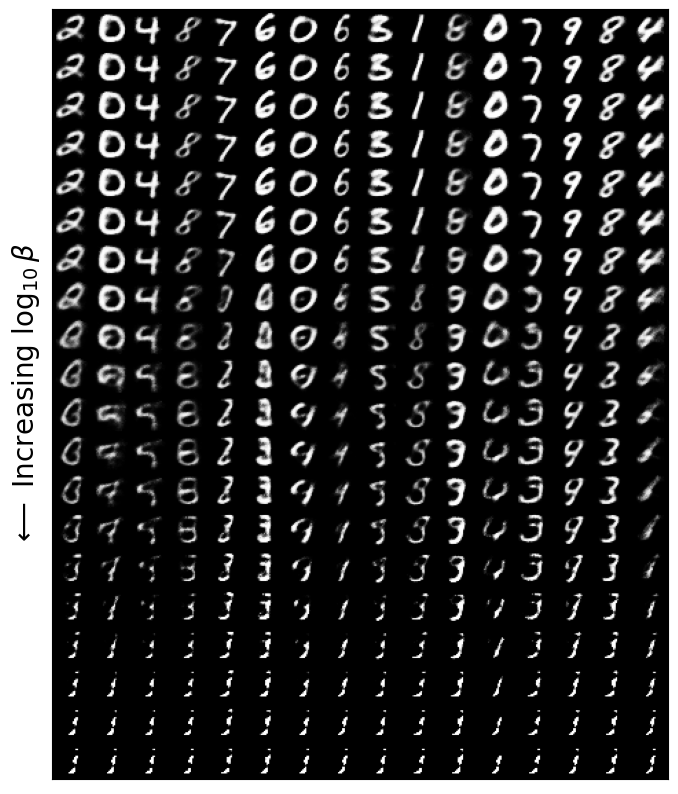

In [79]:
x_reco_list = jnp.array(x_reco_list)
x_samples = rearrange(x_reco_list, "n1 n2 h w 1 -> (n1 h) (n2 w)")

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(x_samples, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel(r'$\longleftarrow~\mathrm{Increasing}~\log_{10} \beta$', rotation=90, fontsize=20);

TODO: Tests of latent-space disentanglement.